In [1]:
! unzip /content/dataiku_assignment-main.zip

Archive:  /content/dataiku_assignment-main.zip
f6e07050f7cfc95a931e26aac7cc1d59d9bd0e3c
   creating: dataiku_assignment-main/
  inflating: dataiku_assignment-main/.gitattributes  
  inflating: dataiku_assignment-main/.gitignore  
   creating: dataiku_assignment-main/.idea/
 extracting: dataiku_assignment-main/.idea/.gitignore  
  inflating: dataiku_assignment-main/.idea/dataiku.iml  
   creating: dataiku_assignment-main/.idea/inspectionProfiles/
  inflating: dataiku_assignment-main/.idea/inspectionProfiles/profiles_settings.xml  
  inflating: dataiku_assignment-main/.idea/misc.xml  
  inflating: dataiku_assignment-main/.idea/modules.xml  
  inflating: dataiku_assignment-main/.idea/vcs.xml  
 extracting: dataiku_assignment-main/README.md  
   creating: dataiku_assignment-main/engine/
   creating: dataiku_assignment-main/engine/__pycache__/
  inflating: dataiku_assignment-main/engine/__pycache__/best_model.cpython-37.pyc  
  inflating: dataiku_assignment-main/engine/__pycache__/optimisat

In [2]:
%cd /content/dataiku_assignment-main

/content/dataiku_assignment-main


In [3]:
import json
# Third party imports
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, preprocessing, feature_selection, ensemble, linear_model, metrics, decomposition
from sklearn.calibration import calibration_curve

# Local module imports
from src.preprocessing import encode_column
from engine.best_model import evaluate_classifiers
from engine.optimisation import get_best_params_for_random_forest,calibrate_random_forest

#read json file
with open('/content/dataiku_assignment-main/json_files/data_cols.json', 'r') as openfile:
  cols = json.load(openfile)

train=pd.read_csv("/content/drive/MyDrive/census_income_learn.csv",header=None,names=cols.keys())
test=pd.read_csv("/content/drive/MyDrive/census_income_test.csv",header=None,names=cols.keys())
train.head()

,age,class_of_worker,detailed_industry_recode,detailed_occupation_recode,education,wage_per_hour,enroll_in_edu_inst_last_wk,marital_stat,major_industry_code,major_occupation_code,...,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veteran's_admin,veterans_benefits,weeks_worked_in_year,year,target
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


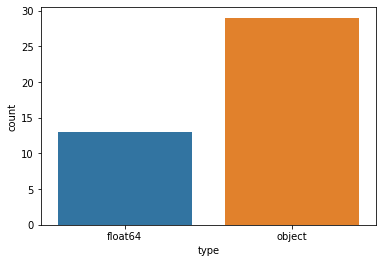

In [4]:
#Print data types segmentation
data_type=pd.DataFrame(train.describe(include='all').dtypes.astype(str).sort_index().sort_values(),columns=["type"]).reset_index()
sns.countplot(x='type', data=data_type)

In [5]:
# Execute data cleaning
"""| The instance weight indicates the number of people in the population
| that each record represents due to stratified sampling.
| To do real analysis and derive conclusions, this field must be used.
| This attribute should *not* be used in the classifiers, so it is
| set to "ignore" in this file."""

train.drop(columns='instance_weight',inplace=True)
test.drop(columns='instance_weight',inplace=True)

In [6]:
# Label Encoding
le = LabelEncoder()
train = train.apply(encode_column, le=le)
test = test.apply(encode_column, le=le)

In [7]:
# Split data into features (X) and target (y)
X_train = train.drop(columns="target")
y_train = train["target"]

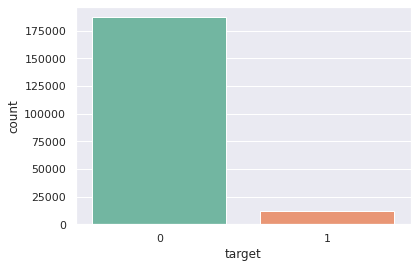

In [8]:
# Plot unbalanced classes
sns.set(style="darkgrid")
ax = sns.countplot(x="target", data=train, palette="Set2")

In [9]:
# Balance classes
rus=SMOTE()
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test = test.drop(columns="target")
y_test = test["target"]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


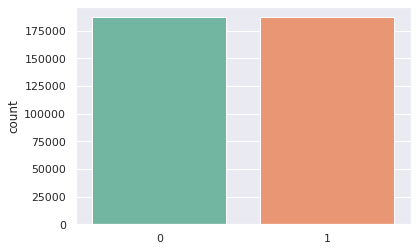

In [10]:
# Plot balanced classes
sns.set(style="darkgrid")
ax = sns.countplot(y_train.values, palette="Set2")

In [11]:
# Loop through different models
classifiers = [
        RandomForestClassifier(),
        GradientBoostingClassifier(),
        DecisionTreeClassifier()
    ]
# Evaluate the classifiers using the evaluate_classifiers function
results = evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test)

# Print the results for each classifier

for result in results:
        print(
            f"{result['classifier']}:"
            f" Recall = {result['recall']:.3f},"
            f" Precision = {result['precision']:.3f}"
            f" F1 = {result['f1']:.3f},"
            f" ROC AUC = {result['roc_auc']:.3f},"
            f" Wilcoxon Stat = {result['wilcoxon_stat']:.3f},"
            f" Wilcoxon p-value = {result['wilcoxon_pvalue']:.3f},"
            f" Train Time = {result['train_time']:.3f}s,"
            f" Eval Time = {result['eval_time']:.3f}s")


RandomForestClassifier: Recall = 0.608, Precision = 0.489 F1 = 0.542, ROC AUC = 0.783, Wilcoxon Stat = 7712254.000, Wilcoxon p-value = 0.000, Train Time = 67.846s, Eval Time = 3.089s
GradientBoostingClassifier: Recall = 0.804, Precision = 0.328 F1 = 0.466, ROC AUC = 0.848, Wilcoxon Stat = 6910824.000, Wilcoxon p-value = 0.000, Train Time = 86.803s, Eval Time = 0.199s
DecisionTreeClassifier: Recall = 0.544, Precision = 0.295 F1 = 0.382, ROC AUC = 0.729, Wilcoxon Stat = 15333750.000, Wilcoxon p-value = 0.000, Train Time = 4.994s, Eval Time = 0.036s


In [12]:
# Output results
results

[{'classifier': 'RandomForestClassifier',
  'recall': 0.6078241189783382,
  'precision': 0.4888831101287219,
  'f1': 0.5419038697124738,
  'roc_auc': 0.782907742142841,
  'wilcoxon_stat': 7712254.0,
  'wilcoxon_pvalue': 1.7962738738668544e-79,
  'train_time': 67.8461983203888,
  'eval_time': 3.089378833770752},
 {'classifier': 'GradientBoostingClassifier',
  'recall': 0.8040737148399612,
  'precision': 0.32799208704253213,
  'f1': 0.46592665448925114,
  'roc_auc': 0.8475837925315477,
  'wilcoxon_stat': 6910824.0,
  'wilcoxon_pvalue': 0.0,
  'train_time': 86.8028621673584,
  'eval_time': 0.1985621452331543},
 {'classifier': 'DecisionTreeClassifier',
  'recall': 0.5441319107662463,
  'precision': 0.2947460595446585,
  'f1': 0.3823696467113484,
  'roc_auc': 0.7290314166124983,
  'wilcoxon_stat': 15333750.0,
  'wilcoxon_pvalue': 0.0,
  'train_time': 4.9943201541900635,
  'eval_time': 0.03563189506530762}]

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


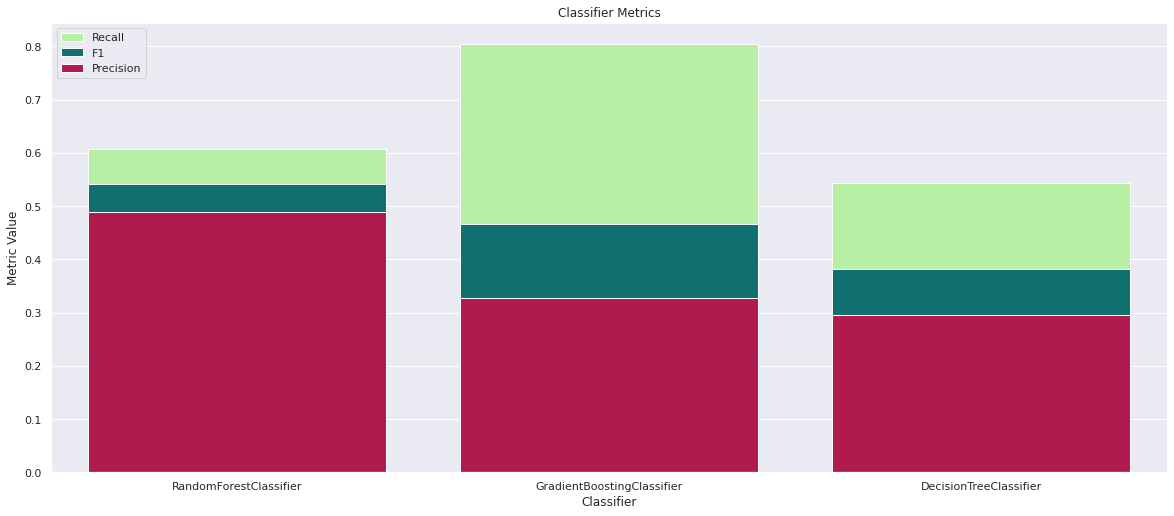

In [13]:
# Plot metrics
sns.set(rc={'figure.figsize':(20,8.27)})
# data to plot
classifiers = [x['classifier'] for x in results]
recalls = [x['recall'] for x in results]
precisions = [x['precision'] for x in results]
f1s = [x['f1'] for x in results]

# create the bar plots
sns.barplot(classifiers, recalls, label='Recall',color=sns.xkcd_rgb['pale light green'])
sns.barplot(classifiers, f1s, label='F1',color='teal')
sns.barplot(classifiers, precisions, label='Precision',color=sns.xkcd_rgb['ruby'])

plt.xlabel('Classifier')
plt.ylabel('Metric Value')
plt.title('Classifier Metrics')
plt.legend(loc='upper left')

plt.show()

In [41]:
# Extract feature importance
df=pd.DataFrame({'col_name': eval(results[0]['classifier'])().fit(X_train, y_train).feature_importances_}, index=X_train.columns).sort_values(by='col_name', ascending=False)

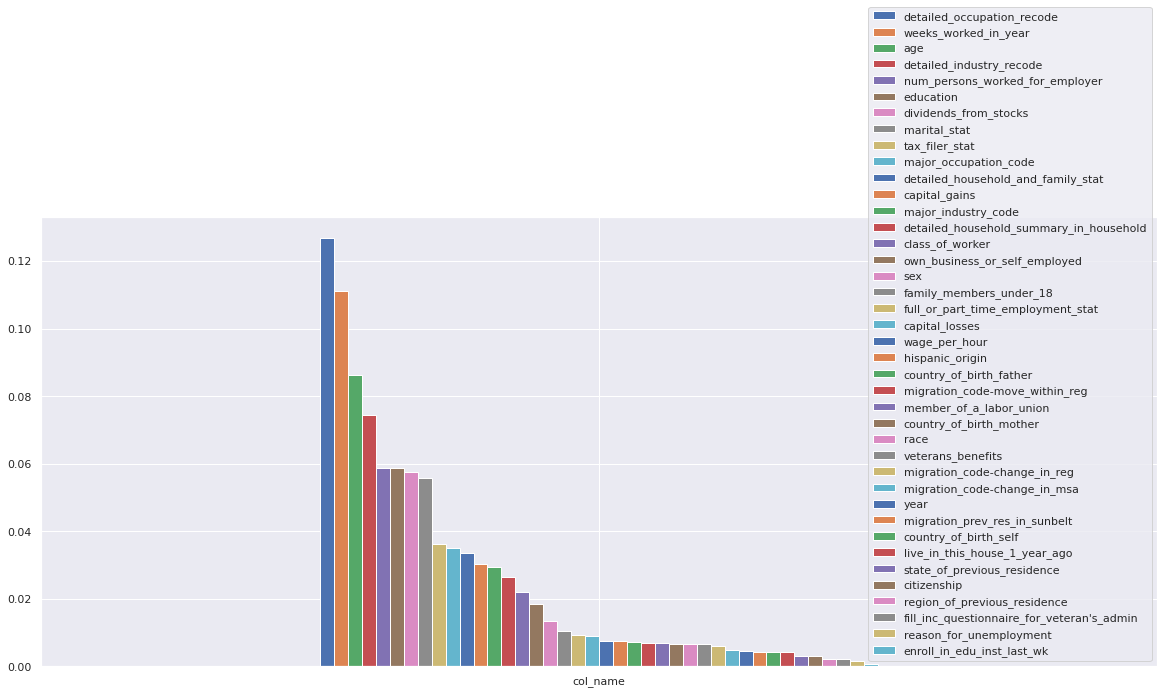

In [44]:
ax = df.T.plot.bar(rot=0)

In [42]:
#set columns name
colx=list(df.head(10).T.columns)

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


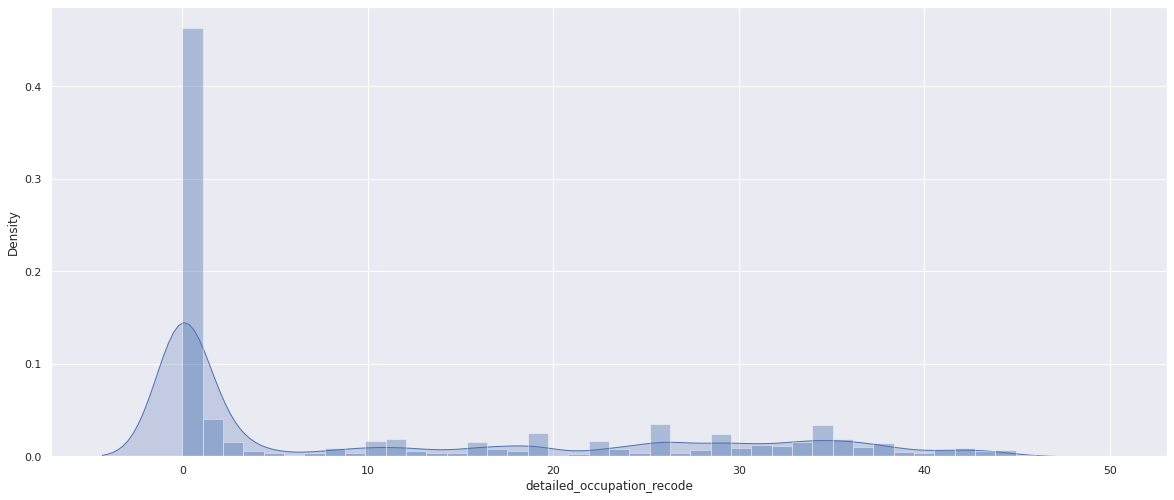

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


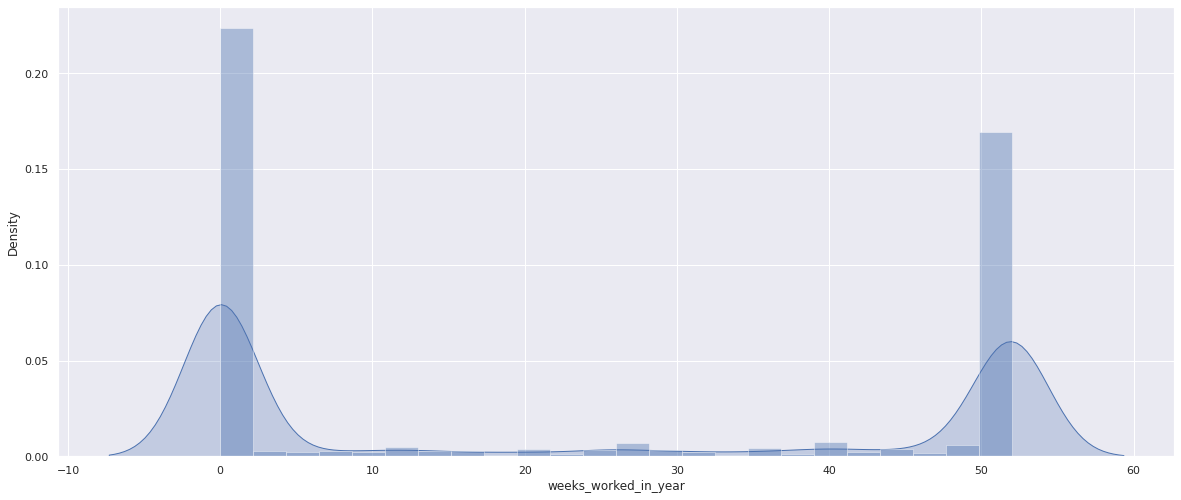

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


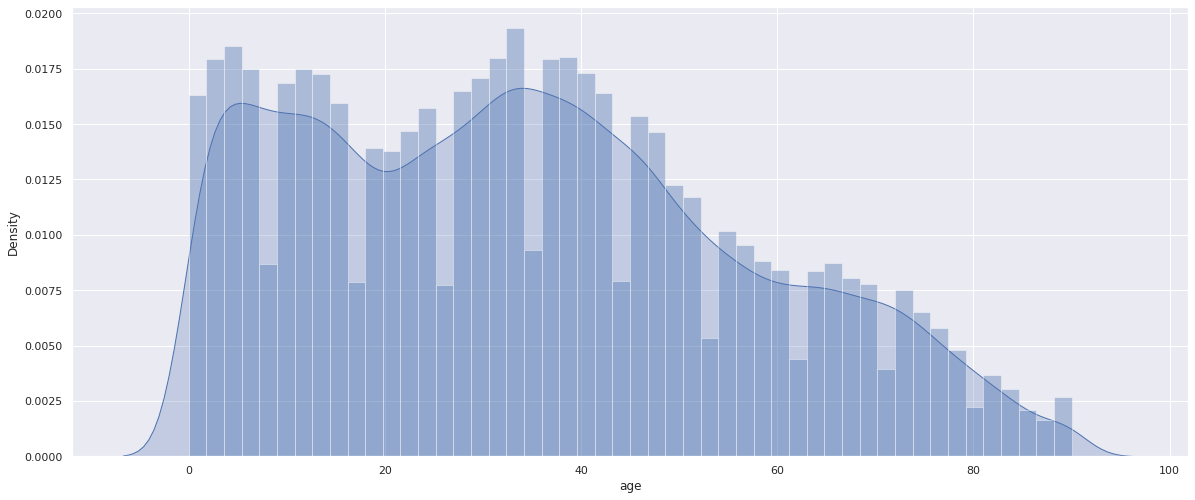

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


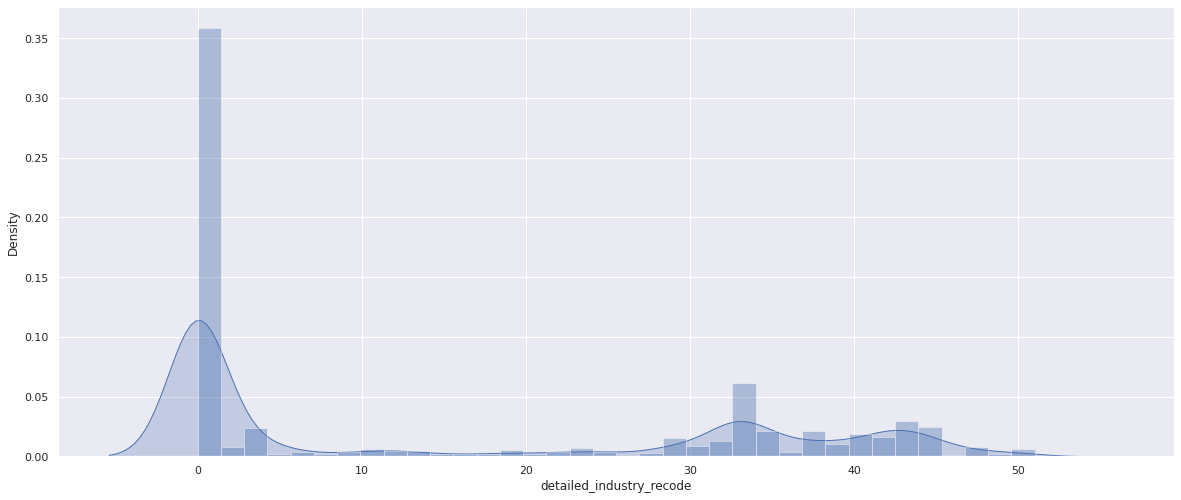

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


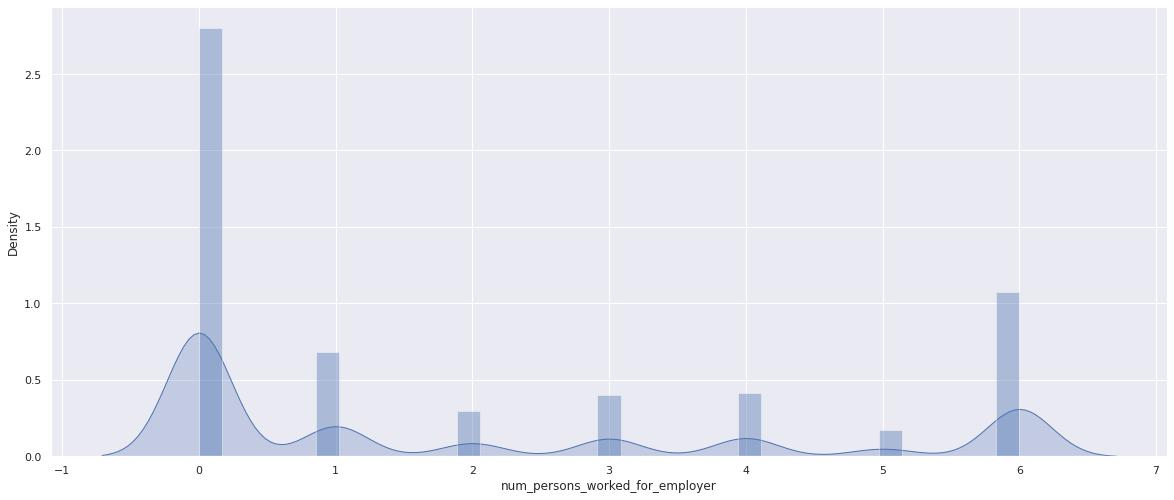

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


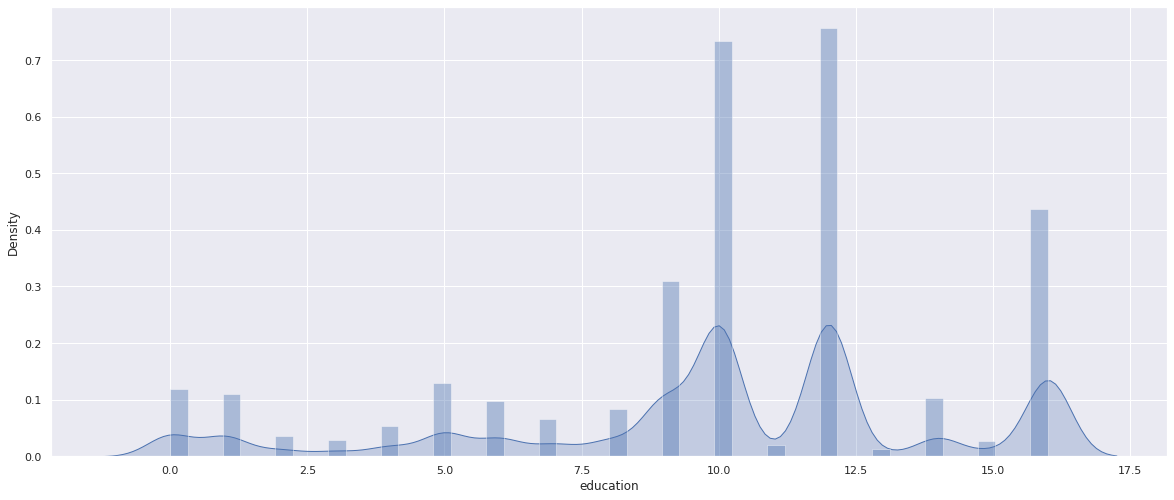

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


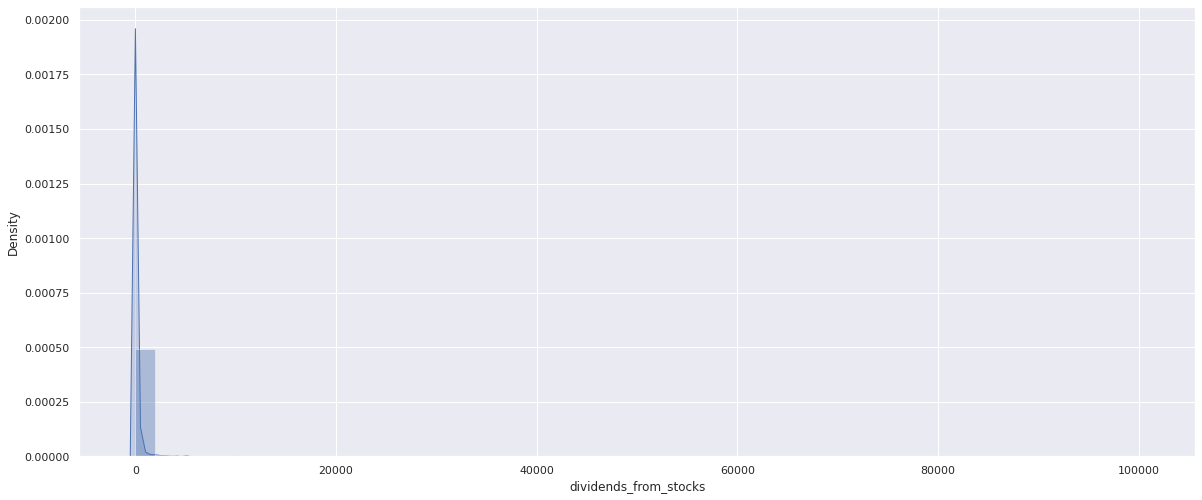

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


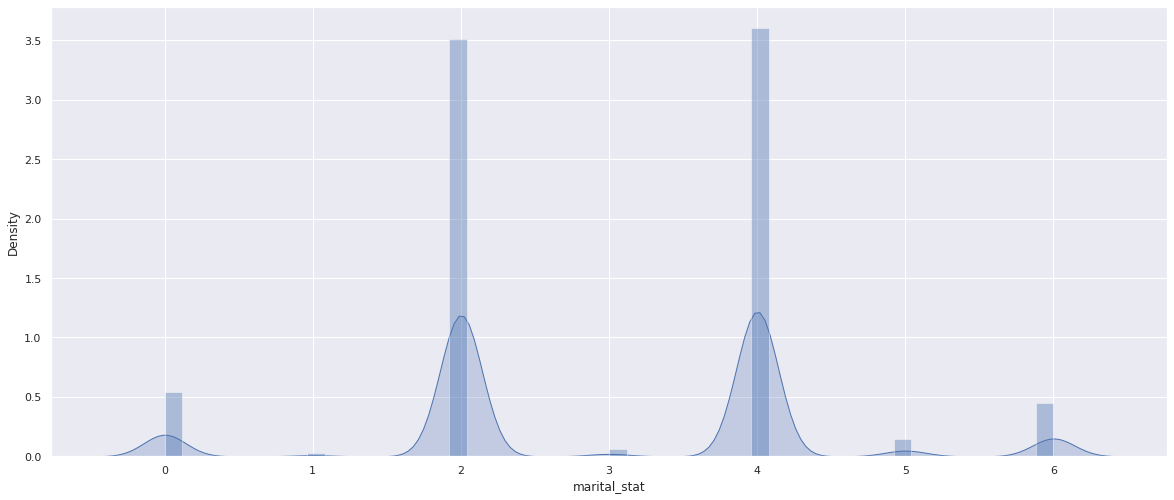

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


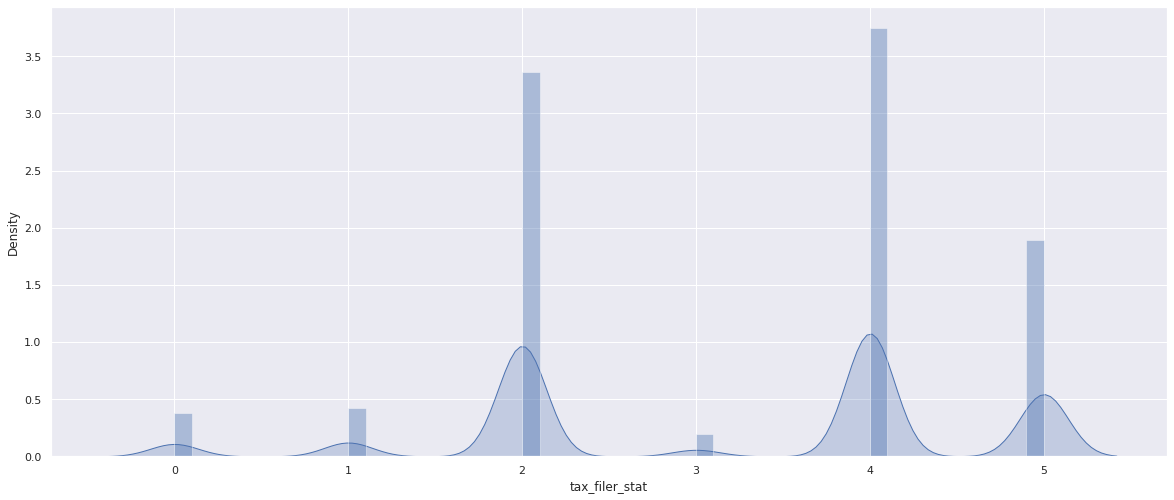

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


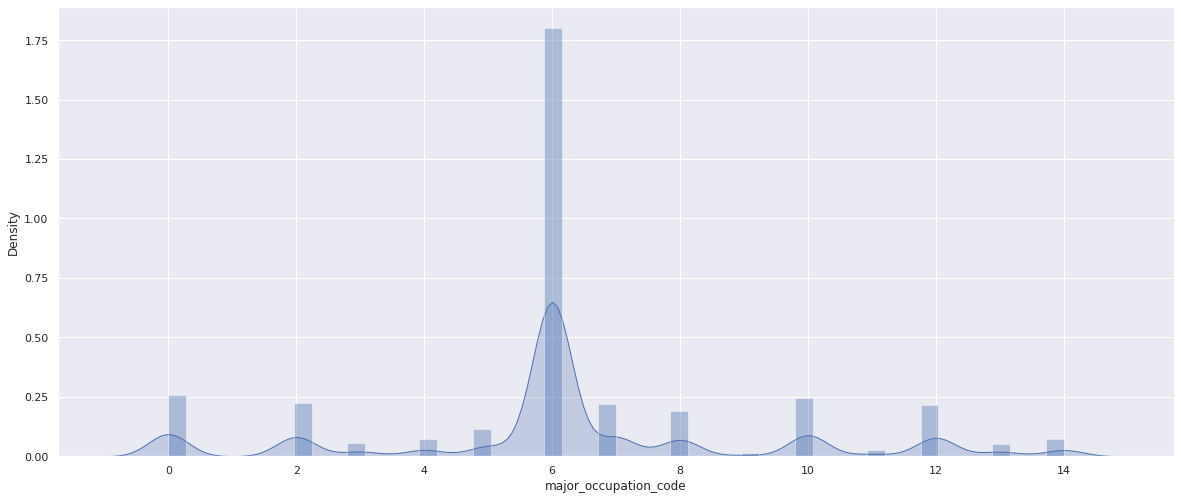

In [47]:
#Analyse top performing categories distribution
for column in colx:
    dtf = test
    # Plot the relationship between the column and the target variable
    #sns.catplot(y=column, x='target', data=dtf, kind='box', aspect=1.5)
    #plt.show()
    variable = dtf[column].fillna(dtf[column].mean())
    sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True})
    plt.show()




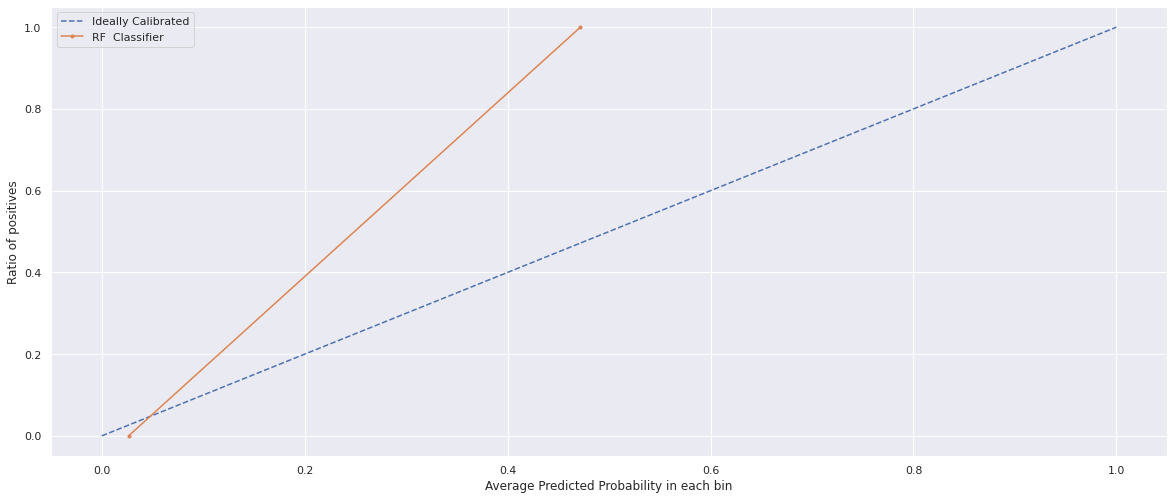

In [22]:
# Plot calibration curve
prob_true, prob_pred = calibration_curve(y_test.values, eval(results[0]['classifier'])().fit(X_train, y_train).predict(X_test.values), n_bins=3)
# Plot perfectly calibrated
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')
 
# Plot model's calibration curve
plt.plot(prob_true, prob_pred, marker = '.', label = 'RF  Classifier')
 
leg = plt.legend(loc = 'upper left')
plt.xlabel('Average Predicted Probability in each bin')
plt.ylabel('Ratio of positives')
plt.show()

Calibrated RandomForestClassifier score on test data: 0.866


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


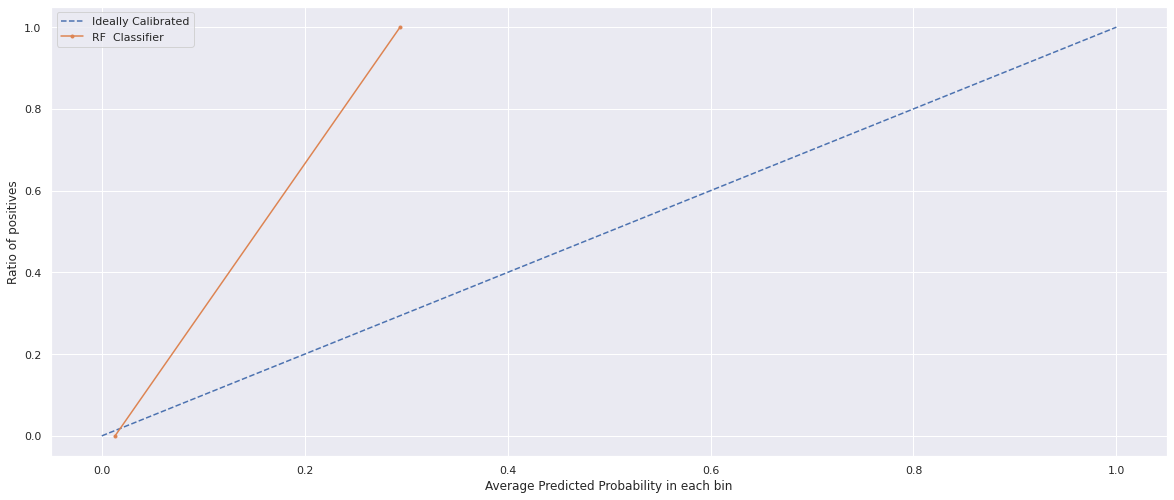

In [48]:
# Get the best parameters for the random forest classifier
best_params = get_best_params_for_random_forest(X_train=X_train, y_train=y_train, random_state=0)

# Calibrate the random forest classifier
calibrated_clf = calibrate_random_forest(X_train, y_train, X_test, y_test,
                                         method="isotonic", random_state=0, best_params=best_params)

# Get the calibration curve for the calibrated random forest classifier
prob_true, prob_pred = calibration_curve(y_test.values, calibrated_clf.predict(X_test.values), n_bins=3)

# Plot the perfectly calibrated curve
plt.plot([0, 1], [0, 1], linestyle = '--', label = 'Ideally Calibrated')

# Plot the calibration curve for the calibrated random forest classifier
plt.plot(prob_true, prob_pred, marker = '.', label = 'RF  Classifier')

# Add a legend to the plot
plt.legend(loc = 'upper left')

# Label the x-axis
plt.xlabel('Average Predicted Probability in each bin')

# Label the y-axis
plt.ylabel('Ratio of positives')

# Display the plot
plt.show()